In [263]:
import numpy as np
import datetime

import torch
import torchvision            
import torch.nn as nn

print(torch.__version__)

1.7.0+cu101


In [264]:
from torch.utils.data import DataLoader



In [265]:
from torchvision import datasets
from torchvision import transforms
import torchvision

In [266]:
#import matplotlib

%matplotlib inline
from matplotlib.pyplot import imshow, imsave

In [267]:
MODEL_NAME = 'CNN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

MODEL_NAME = CNN, DEVICE = cuda


In [268]:
transform = transforms.Compose(
    [transforms.ToTensor() ])                              # image to tensor

In [269]:
 # create and use a transform
 mnist_train = datasets.MNIST(root='./data/', train=True,transform=transform, download=True)
 mnist_test = datasets.MNIST(root='./data/', train=False,transform=transform, download=True)

# create and use a transform
fashion_train = datasets.FashionMNIST('./data/', download=True, train=True, transform=transform)
fashion_test = datasets.FashionMNIST('./data/', download=True, train=False, transform=transform)

In [270]:
!pwd

/content


## Creating Directories

In [271]:
!mkdir "./train"
!mkdir "./test"

for i in range(20):
    train = "./train/" + str(i)
    test = "./test/" + str(i)
    !mkdir $train
    !mkdir $test



mkdir: cannot create directory ‘./train’: File exists
mkdir: cannot create directory ‘./test’: File exists
mkdir: cannot create directory ‘./train/0’: File exists
mkdir: cannot create directory ‘./test/0’: File exists
mkdir: cannot create directory ‘./train/1’: File exists
mkdir: cannot create directory ‘./test/1’: File exists
mkdir: cannot create directory ‘./train/2’: File exists
mkdir: cannot create directory ‘./test/2’: File exists
mkdir: cannot create directory ‘./train/3’: File exists
mkdir: cannot create directory ‘./test/3’: File exists
mkdir: cannot create directory ‘./train/4’: File exists
mkdir: cannot create directory ‘./test/4’: File exists
mkdir: cannot create directory ‘./train/5’: File exists
mkdir: cannot create directory ‘./test/5’: File exists
mkdir: cannot create directory ‘./train/6’: File exists
mkdir: cannot create directory ‘./test/6’: File exists
mkdir: cannot create directory ‘./train/7’: File exists
mkdir: cannot create directory ‘./test/7’: File exists
mkdir

In [272]:
# saving training images

train_count = np.zeros(20)

for mnist_index in range(10):
    i = 0
    j = 0
    while j < 2000:
        temp_image, temp_lable = mnist_train[i]
        i = i + 1
        if temp_lable == mnist_index:
            path = "./train/" + str(temp_lable) + "/" + str(j) + ".jpg"
            torchvision.utils.save_image(temp_image, path)
            train_count[mnist_index] = j
            j = j + 1
            

for fashion_index in range(10):
    i = 0
    j = 0
    while j < 2000:
        temp_image, temp_lable = fashion_train[i]
        i = i + 1
        if temp_lable == fashion_index:
            path = "./train/" + str(temp_lable+10) + "/" + str(j) + ".jpg"
            torchvision.utils.save_image(temp_image, path)
            train_count[fashion_index+10] = j
            j = j + 1
            


In [273]:
# saving test images

test_count = np.zeros(20)

for mnist_index in range(10):
    i = 0
    j = 0
    while j < 1000 and i < 10000:
        temp_image, temp_lable = mnist_test[i]
        i = i + 1
        if temp_lable == mnist_index:
            path = "./test/" + str(temp_lable) + "/" + str(j) + ".jpg"
            torchvision.utils.save_image(temp_image, path)
            test_count[mnist_index] = j
            j = j + 1
            

for fashion_index in range(10):
    i = 0
    j = 0
    while j < 1000 and i < 10000:
        temp_image, temp_lable = fashion_test[i]
        i = i + 1
        if temp_lable == fashion_index:
            path = "./test/" + str(temp_lable+10) + "/" + str(j) + ".jpg"
            torchvision.utils.save_image(temp_image, path)
            test_count[fashion_index+10] = j
            j = j + 1
            

## Dateset 만들기

In [274]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

from skimage import data


In [275]:
class MyDataset(Dataset):

    def __init__(self, train, instance_count, root_dir, transform=None):
        
        self.train = train
        self.instance_count = instance_count
        self.root_dir = root_dir
        self.transform = transform
        if train:
            path = "./train/"
        else:
            path = "./test/"

        # 이미지 읽어오기
        self.samples = []
        for lable_index in range(20):
            j = 0
            while j < instance_count[lable_index]:
                temp_image = io.imread(path + str(lable_index) + "/" + str(j) + ".jpg", as_gray=True)
                self.samples.append((temp_image, lable_index))
                j = j + 1

    def __len__(self):
        return int(self.instance_count.sum())

    def __getitem__(self, idx):

        if self.transform:
            trans_image, lable = self.samples[idx]
            trans_image = self.transform(trans_image)
            return (trans_image, lable)

        return self.samples[idx]

In [276]:
transform = transforms.Compose(
    [transforms.ToTensor(),                               # image to tensor
     transforms.Normalize(mean=(0.1307,), std=(0.3081,))  # normalize to "(x-mean)/std"
    ])

In [277]:
train_dataset = MyDataset(train = True, instance_count = train_count, root_dir = "./Mydata/train/", transform = transform)
test_dataset = MyDataset(train = False, instance_count = test_count, root_dir = "./Mydata/test/", transform = transform)



In [278]:
batch_size = 1000


In [279]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False, drop_last=False)

In [280]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [281]:
class MyCNN(nn.Module):
    """
        Simple CNN Clssifier
    """
    def __init__(self, num_classes=20):
        super(MyCNN, self).__init__()
        
        self.conv = nn.Sequential(
            # (N, 1, 28, 28) 여기서 N은 배치 사이즈
            nn.Conv2d(1, 64, kernel_size=3, stride=1, dilation =3, padding=4), # 2차원 convolution layer
            # 얘의 결과는 (N, 64, 28, 28),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            # MAx Pooling 결과는  (N, 64, 14, 14)

            # (N, 64, 14, 14)
            nn.Conv2d(64, 512, kernel_size=3, stride=1, padding=1),
            # 결과는 (N, 512, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # (N, 512, 7 , 7) 배치, 채널, height, width

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            # 결과는 (N, 1024, 7, 7)
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
            # (N, 1024, 6, 6) 배치, 채널, height, width

        )
        self.fc = nn.Sequential( # 여기부터 fully connected라서 바꿔줘야 함, 여기부터는 2차원
            nn.Linear(6*6*1024, 512), # 512는 output node
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        y_ = self.conv(x) # (N, 64, 7, 7) # cnn은 input이 삼차원이니까 그대로 넣어준다.
        y_ = y_.view(y_.size(0), -1) # (N, 64*7*7) # 3차원을 일렬로 된 모양으로 바꿔준다.
        y_ = self.fc(y_)
        return y_

## 모델 설명

우선 Fashion Mnist 와 Mnist의 이미지를 실제로 보면 가장 큰 차이는 하얀 픽셀들의 밀집도이다. 즉, 숫자 이미지인 mnist 데이터셋은 그림의 영역을 나타내는 부분들이 더 얇게 분포되어있고, 옷 이미지인 Fashion Mnist는 좀 더 밀집되어 두꺼운 분포를 가진다. 따라서 이런 큰 카테고리 상에서의 차이를 학습하려면 커널의 사이즈가 어느 정도 커야 그 context를 파악할 수 있을 것이다. 그러나 커널을 키워버리면 적은 파라미터라는 CNN의 장점이 없어진다. 따라서 작은 커널로도 넓은 Context를 확보할 수 있는 dilated convolution layer를 첫 Layer로 사용하였다.

Batch의 경우 현재 데이터 셋에 mnist와 fashion dataset이 섞여있기 때문에 너무 작은 사이즈를 설정한다면 두 데이터셋의 분포가 고르지 않을 상황을 염려하여 최대한 큰 사이즈로 설정하였다. 대신에 학습 시에 epoch을 늘려서 학습 횟수를 보장하였다.

In [282]:
model = MyCNN().to(DEVICE)

In [283]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [284]:
all_losses = []

In [285]:
max_epoch = 50        # maximum number of epochs
step = 0             # initialize step counter variable

plot_every = 200
total_loss = 0 # Reset every plot_every iters

start = time.time()

for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(train_loader):
        # Training Discriminator
        x, y = images.to(DEVICE,  dtype = torch.float), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
        
        #print(x.dtype)
        y_hat = model(x)      # (N, 10)  # forward propagation
       
        loss = criterion(y_hat, y)  # computing loss
        total_loss += loss.item()
          
        optim.zero_grad()           # reset gradient
        loss.backward()             # back-propagation (compute gradient)
        optim.step()                # update parameters with gradient
        
        # periodically print loss
        if step % 120 == 0:
            print('Epoch({}): {}/{}, Step: {}, Loss: {}'.format(timeSince(start), epoch, max_epoch, step, loss.item()))
        
        if (step + 1) % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
        
        # periodically evalute model on test data
        if step % 250 == 0:
            model.eval()
            acc = 0.
            with torch.no_grad():   # disable autograd
                for idx, (images, labels) in enumerate(test_loader):
                    x, y = images.to(DEVICE, dtype=torch.float), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
                    
                    y_hat = model(x) # (N, 10)
                    loss = criterion(y_hat, y)
                    _, indices = torch.max(y_hat, dim=-1)     # find maxmum along the last axis (argmax of each row)
                                                              # ex) max_value, max_idx = torch.max(input, dim)
                    acc += torch.sum(indices == y).item()     # count correctly classified samples
                                                              # torch.sum() returns Tensor. Tensor.item() converts it to a value
            print('*'*20, 'Test', '*'*20)
            print('Step: {}, Loss: {}, Accuracy: {} %'.format(step, loss.item(), acc/test_count.sum()*100))
            print('*'*46)
            model.train()           # turn to train mode (enable autograd)
        step += 1

Epoch(0m 0s): 0/50, Step: 0, Loss: 3.0023140907287598
******************** Test ********************
Step: 0, Loss: 0.007223741617053747, Accuracy: 12.440554487503794 %
**********************************************
Epoch(0m 24s): 3/50, Step: 120, Loss: 0.2447749674320221
Epoch(0m 45s): 6/50, Step: 240, Loss: 0.18030129373073578
******************** Test ********************
Step: 250, Loss: 0.08731666952371597, Accuracy: 92.68440756855206 %
**********************************************
Epoch(1m 9s): 9/50, Step: 360, Loss: 0.11911100149154663
Epoch(1m 30s): 12/50, Step: 480, Loss: 0.11614209413528442
******************** Test ********************
Step: 500, Loss: 0.11552900820970535, Accuracy: 93.72660123444298 %
**********************************************
Epoch(1m 55s): 15/50, Step: 600, Loss: 0.05544350668787956
Epoch(2m 16s): 18/50, Step: 720, Loss: 0.06652700155973434
******************** Test ********************
Step: 750, Loss: 0.05270072817802429, Accuracy: 94.2527572599413

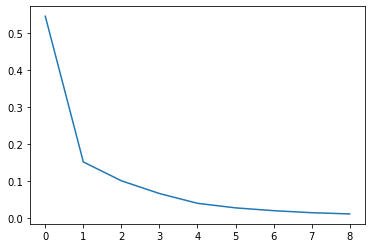

In [286]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [287]:
# Test
model.eval()
acc = 0.
with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        x, y = images.to(DEVICE, dtype=torch.float), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
        y_hat = model(x) # (N, 10)
        loss = criterion(y_hat, y)
        _, indices = torch.max(y_hat, dim=-1)
        acc += torch.sum(indices == y).item()
print('*'*20, 'Test', '*'*20)
print('Step: {}, Loss: {}, Accuracy: {} %'.format(step, loss.item(), acc/test_count.sum()*100))
print('*'*46)

******************** Test ********************
Step: 1950, Loss: 0.15849801898002625, Accuracy: 94.10604067590812 %
**********************************************
